Device: cuda
Total images: 8544
Train: 6835 | Val: 1709
Classes: 74


Epoch 1/20: 100%|██████████| 214/214 [11:39<00:00,  3.27s/it]


[Epoch 1] loss=825.6546 | val_acc=0.3347


Epoch 2/20: 100%|██████████| 214/214 [12:07<00:00,  3.40s/it]


[Epoch 2] loss=629.3892 | val_acc=0.4634


Epoch 3/20: 100%|██████████| 214/214 [11:37<00:00,  3.26s/it]


[Epoch 3] loss=542.4541 | val_acc=0.5354


Epoch 4/20: 100%|██████████| 214/214 [11:33<00:00,  3.24s/it]


[Epoch 4] loss=488.1796 | val_acc=0.5559


Epoch 5/20: 100%|██████████| 214/214 [11:35<00:00,  3.25s/it]


[Epoch 5] loss=447.6197 | val_acc=0.6004


Epoch 6/20: 100%|██████████| 214/214 [11:35<00:00,  3.25s/it]


[Epoch 6] loss=398.8940 | val_acc=0.6039


Epoch 7/20: 100%|██████████| 214/214 [11:33<00:00,  3.24s/it]


[Epoch 7] loss=389.8703 | val_acc=0.6185


Epoch 8/20: 100%|██████████| 214/214 [11:32<00:00,  3.24s/it]


[Epoch 8] loss=369.6542 | val_acc=0.6249


Epoch 9/20: 100%|██████████| 214/214 [11:31<00:00,  3.23s/it]


[Epoch 9] loss=372.6143 | val_acc=0.6384


Epoch 10/20: 100%|██████████| 214/214 [11:45<00:00,  3.30s/it]


[Epoch 10] loss=327.2805 | val_acc=0.6343


Epoch 11/20: 100%|██████████| 214/214 [12:00<00:00,  3.37s/it]


[Epoch 11] loss=312.9418 | val_acc=0.6437


Epoch 12/20: 100%|██████████| 214/214 [11:38<00:00,  3.26s/it]


[Epoch 12] loss=299.1133 | val_acc=0.6548


Epoch 13/20: 100%|██████████| 214/214 [12:24<00:00,  3.48s/it]


[Epoch 13] loss=283.6395 | val_acc=0.6530


Epoch 14/20: 100%|██████████| 214/214 [11:44<00:00,  3.29s/it]


[Epoch 14] loss=292.0045 | val_acc=0.6635


Epoch 15/20: 100%|██████████| 214/214 [11:33<00:00,  3.24s/it]


[Epoch 15] loss=290.9109 | val_acc=0.6594


Epoch 16/20: 100%|██████████| 214/214 [11:31<00:00,  3.23s/it]


[Epoch 16] loss=257.1926 | val_acc=0.6717


Epoch 17/20: 100%|██████████| 214/214 [15:00:17<00:00, 252.42s/it]      


[Epoch 17] loss=274.9057 | val_acc=0.6559


Epoch 18/20: 100%|██████████| 214/214 [11:32<00:00,  3.23s/it]


[Epoch 18] loss=279.5285 | val_acc=0.6489


Epoch 19/20: 100%|██████████| 214/214 [11:42<00:00,  3.28s/it]


[Epoch 19] loss=282.1723 | val_acc=0.6536


Epoch 20/20: 100%|██████████| 214/214 [11:48<00:00,  3.31s/it]


[Epoch 20] loss=275.9330 | val_acc=0.6571

Best Validation Accuracy: 0.6717378583967232


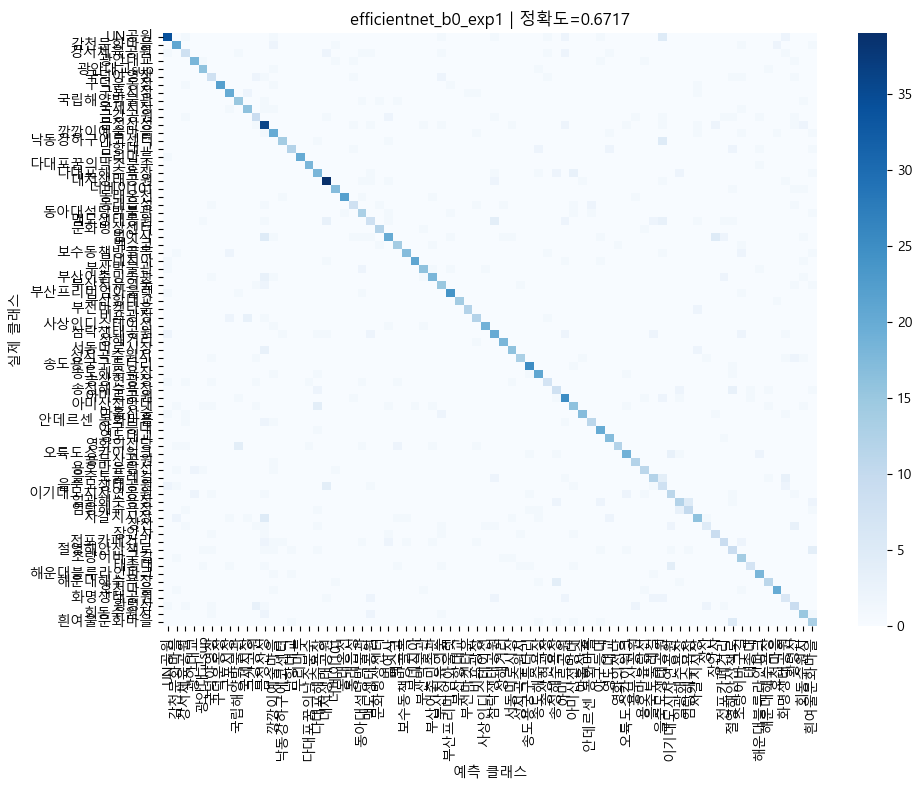

Model saved: results/efficientnet_b0_exp1.pth
Heatmap saved: results/efficientnet_b0_exp1_confusion_matrix.png


In [5]:
# ==================================================
# EfficientNet Image Classification
# Single Folder Dataset + Augmentation + MixUp
# ==================================================

import os
import random
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import timm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm


# ===============================
# 1. 설정
# ===============================
DATA_DIR = "이미지"
RESULT_DIR = "./results"
os.makedirs(RESULT_DIR, exist_ok=True)

MODEL_NAME = "efficientnet_b0"
SAVE_NAME = f"{MODEL_NAME}_exp1"

IMG_SIZE = 299
BATCH_SIZE = 32
EPOCHS = 20
LR = 1e-4
VAL_RATIO = 0.2
SEED = 42

MIXUP_ALPHA = 0.4   # 0이면 MixUp 미사용

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

print("Device:", device)

# ===============================
# 2. Augmentation
# ===============================
train_tf = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(
        brightness=0.3,
        contrast=0.3,
        saturation=0.3,
        hue=0.05
    ),
    transforms.ToTensor()
])

val_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

# ===============================
# 3. Dataset & Split
# ===============================
full_dataset = datasets.ImageFolder(DATA_DIR)
NUM_CLASSES = len(full_dataset.classes)
CLASS_NAMES = full_dataset.classes

indices = list(range(len(full_dataset)))
random.shuffle(indices)

split = int(len(indices) * (1 - VAL_RATIO))
train_idx, val_idx = indices[:split], indices[split:]

train_ds = Subset(
    datasets.ImageFolder(DATA_DIR, transform=train_tf),
    train_idx
)

val_ds = Subset(
    datasets.ImageFolder(DATA_DIR, transform=val_tf),
    val_idx
)

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4
)

print(f"Total images: {len(full_dataset)}")
print(f"Train: {len(train_ds)} | Val: {len(val_ds)}")
print(f"Classes: {NUM_CLASSES}")

# ===============================
# 4. MixUp 함수
# ===============================
def mixup_data(x, y, alpha=0.4):
    if alpha <= 0:
        return x, y, y, 1.0

    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]

    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# ===============================
# 5. 모델
# ===============================
model = timm.create_model(MODEL_NAME, pretrained=True)
model.classifier = nn.Linear(
    model.classifier.in_features,
    NUM_CLASSES
)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# ===============================
# 6. 학습
# ===============================
best_acc = 0.0
best_preds, best_labels = [], []

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0

    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        x, y = x.to(device), y.to(device)

        # ---- MixUp 적용 ----
        x, y_a, y_b, lam = mixup_data(x, y, MIXUP_ALPHA)

        optimizer.zero_grad()
        out = model(x)
        loss = mixup_criterion(criterion, out, y_a, y_b, lam)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # ===== Validation =====
    model.eval()
    preds, labels = [], []

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            out = model(x)
            pred = torch.argmax(out, dim=1).cpu().numpy()

            preds.extend(pred)
            labels.extend(y.numpy())

    acc = accuracy_score(labels, preds)
    print(f"[Epoch {epoch+1}] loss={train_loss:.4f} | val_acc={acc:.4f}")

    if acc > best_acc:
        best_acc = acc
        best_preds = preds
        best_labels = labels
        torch.save(
            model.state_dict(),
            os.path.join(RESULT_DIR, f"{SAVE_NAME}.pth")
        )

# ===============================
# 7. 결과 (Accuracy + Heatmap)
# ===============================
print("\nBest Validation Accuracy:", best_acc)

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ---- 한글 폰트 설정 (Windows) ----
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

cm = confusion_matrix(best_labels, best_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    cmap="Blues",
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES
)

plt.xlabel("예측 클래스")
plt.ylabel("실제 클래스")
plt.title(f"{SAVE_NAME} | 정확도={best_acc:.4f}")
plt.tight_layout()

plt.savefig(
    os.path.join(RESULT_DIR, f"{SAVE_NAME}_confusion_matrix.png"),
    dpi=300
)
plt.show()

print(f"Model saved: results/{SAVE_NAME}.pth")
print(f"Heatmap saved: results/{SAVE_NAME}_confusion_matrix.png")
